In [2]:
import matplotlib.pyplot as plt
from matplotlib.pylab import mpl
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
import hiddenlayer
import torchviz
import torch
import torchvision
import torch.utils.data as torch_utils_data
import torchvision.datasets as torchvison_data
import  torchvision.transforms as torchvison_trans
import sklearn.datasets as sklearn_datasets
import sklearn.decomposition as sklearn_decompose
import sklearn.preprocessing as sklearn_processing
import sklearn.metrics as sklearn_metric
import sklearn.manifold as sklearn_manifold
import sklearn.model_selection as sklearn_model_selection
import tensorboardX
import seaborn as sns
import copy
plt.rcParams['font.sans-serif'] = ['Times New Roman']  # 设置字体风格,必须在前然后设置显示中文
mpl.rcParams['font.size'] = 10.5  # 图片字体大小
mpl.rcParams['font.sans-serif'] = ['SimHei']  # 显示中文的命令
mpl.rcParams['axes.unicode_minus'] = False  # 显示负号的命令
mpl.rcParams['agg.path.chunksize'] = 10000
plt.rcParams['figure.figsize'] = (7.8, 3.8)  # 设置figure_size尺寸
plt.rcParams['savefig.dpi'] = 600  # 图片像素
#plt.rcParams['figure.dpi'] = 600  # 分辨率
root = os.path.join(os.getcwd(), "ImageProcessing")
img_dir = os.path.join(root, "images")

In [3]:
vgg16 = torchvision.models.vgg16(pretrained=True)

vgg = vgg16.features # 只使用特征提取层，不包括全连接
# vgg.training = False
# for param in vgg.parameters():
#     param.requires_grad_(False) # 不可训练

batch_size = 32

train_transform = torchvison_trans.Compose([
    torchvison_trans.transforms.RandomSizedCrop(224), # vgg16输入是224
    torchvison_trans.transforms.RandomHorizontalFlip(),
    torchvison_trans.transforms.ToTensor(),
    torchvison_trans.transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
val_transform = torchvison_trans.Compose([
    torchvison_trans.transforms.Resize(256), # vgg16输入是224
    torchvison_trans.transforms.CenterCrop(224), # 从给定的size中心裁剪
    torchvison_trans.transforms.ToTensor(),
    torchvison_trans.transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

root = "C:\\Users\\chenb\\.torch\\10-monkey-species\\"
train_data = torchvison_data.ImageFolder(root=root+"training",transform=train_transform)
val_data = torchvison_data.ImageFolder(root=root+"validation",transform=val_transform)

train_loader = torch_utils_data.DataLoader(train_data,batch_size=batch_size,shuffle=True,num_workers=2)
val_loader = torch_utils_data.DataLoader(val_data,batch_size=batch_size,shuffle=True,num_workers=2)


c:\users\chenb\appdata\local\programs\python\python37\lib\site-packages\torchvision\transforms\transforms.py:917: UserWarning: The use of the transforms.RandomSizedCrop transform is deprecated, please use transforms.RandomResizedCrop instead.
  warnings.warn("The use of the transforms.RandomSizedCrop transform is deprecated, " +


In [4]:
class MyVgg16(torch.nn.Module):
    def __init__(self):
        super(MyVgg16, self).__init__()
        self.vgg = vgg
        # 自定义的全连接层
        self.classifier = torch.nn.Sequential(
            torch.nn.Flatten(), # 512*7*7=25088
            torch.nn.Linear(25088,512),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(512,256),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(256,10),
            torch.nn.Softmax(dim=1)
        )
    def forward(self,x):
        x = self.vgg(x)
        #print(x.shape)# 32, 512, 7, 7
        x = self.classifier(x)
        return x
class MyCNN(torch.nn.Module):
    def __init__(self):
        super(MyCNN,self).__init__()
        self.conv1 = torch.nn.Sequential(
            # 227 - 5  + 1 = 223
            torch.nn.Conv2d(in_channels=3,out_channels=16,kernel_size=(5,5)),
            torch.nn.ReLU(),
            torch.nn.AvgPool2d(kernel_size=3,stride=2),)
        # 第二个卷积层 : (N,16,111,111)->(N,32,53,53)
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(16,32,(5,5)),
            torch.nn.ReLU(),
            torch.nn.AvgPool2d(3,2)
        )
        # (N, 32, 53, 53)->(N, 64,25,25)
        self.conv3 = torch.nn.Sequential(
            torch.nn.Conv2d(32,64,(3,3)),
            torch.nn.ReLU(),
            torch.nn.AvgPool2d(3,2)
        )
        # (N, 128,11,11)
        self.conv4 = torch.nn.Sequential(
            torch.nn.Conv2d(64,128,(3,3)),
            torch.nn.ReLU(),
            torch.nn.AvgPool2d(3,2)
        )
        # (N, 256,4,4)
        self.conv5 = torch.nn.Sequential(
            torch.nn.Conv2d(128,256,(3,3)),
            torch.nn.ReLU(),
            torch.nn.AvgPool2d(3,2)
        )
        # 全连接输入(N,256*4*4)->(N,)
        self.classifier = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(in_features=256*9,out_features=256*4,bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(256*4,256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 10),
            #torch.nn.Softmax(dim=1)
        )
    def forward(self,input):
        x  = self.conv1(input)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.classifier(x)
        return x
model = MyVgg16()
print(model)

MyVgg16(
  (vgg): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1,

In [5]:
# torch.save(model,root+"10_monkey_species_model_jupyter.pkl")
model_new = torch.load(root+"10_monkey_species_model_jupyter.pkl")

In [6]:
Loader = torch_utils_data.DataLoader(train_data,batch_size=32,shuffle=True,num_workers=2)
for idx , (x,y) in enumerate(Loader):
    output = model_new(x)
    label = torch.argmax(output,dim=1)
    num = torch.sum(label==y)
    print(idx,num/len(y))# 验证多个batch

c:\users\chenb\appdata\local\programs\python\python37\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


0 tensor(0.8125)
1 tensor(0.7812)
2 tensor(0.8438)
3 tensor(0.8750)
4 tensor(0.7812)
5 tensor(0.8750)
6 tensor(0.8438)
7 tensor(0.8438)
8 tensor(0.8125)
9 tensor(0.7188)
10 tensor(0.7812)
11 tensor(0.7500)
12 tensor(0.8125)
13 tensor(0.7188)
14 tensor(0.7500)
15 tensor(0.7812)
16 tensor(0.7188)
17 tensor(0.7500)
18 tensor(0.7812)
19 tensor(0.7188)
20 tensor(0.7812)
21 tensor(0.7500)
22 tensor(0.8750)
23 tensor(0.9062)
24 tensor(0.7500)
25 tensor(0.9062)
26 tensor(0.7500)
27 tensor(0.8750)
28 tensor(0.8125)
29 tensor(0.8438)
30 tensor(0.6250)
31 tensor(0.7500)
32 tensor(0.8125)
33 tensor(0.8125)
34 tensor(0.8889)


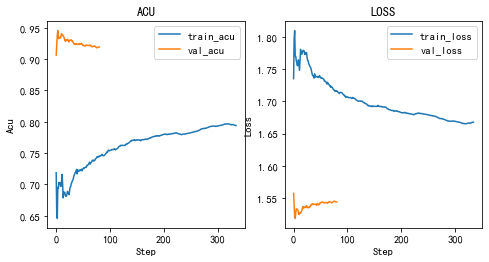

In [23]:
def plot_train_val():
    plt.subplot(121)
    plt.plot(train_acu_lst,label="train_acu")
    plt.plot(val_acu_lst,label="val_acu")
    plt.xlabel("Step")
    plt.ylabel("Acu")
    plt.title("ACU")
    plt.legend()
    plt.subplot(122)
    plt.plot(train_loss_lst,label="train_loss")
    plt.plot(val_loss_lst,label="val_loss")
    plt.xlabel("Step")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("LOSS")
    plt.show()
plot_train_val()